<a href="https://colab.research.google.com/github/Kirti-Pant/X-RVV-/blob/main/GRADCAM_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GradCAM Implementation

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


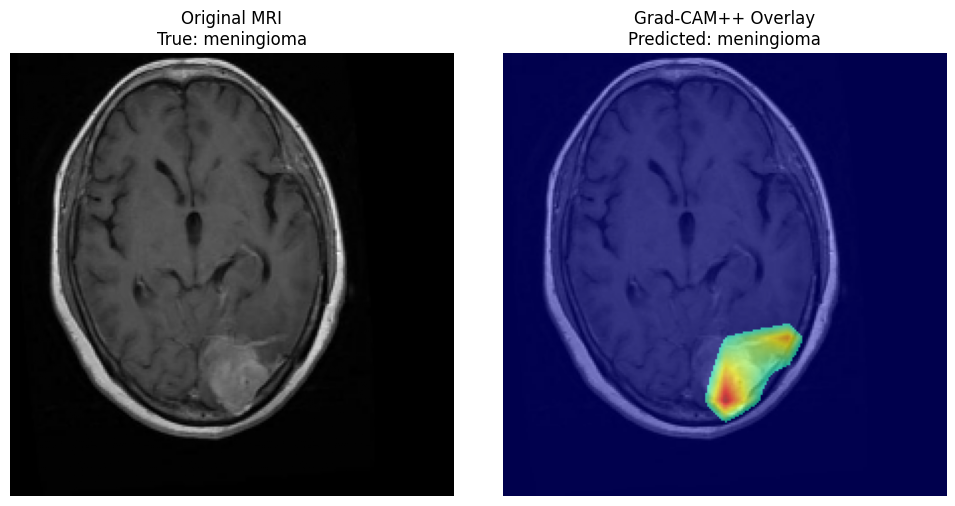

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from transformers import TFViTModel
import keras


@keras.saving.register_keras_serializable()
class ViTBranch(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    def call(self, inputs, training=False):
        return self.vit({'pixel_values': inputs}, training=training).last_hidden_state[:, 0, :]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 768)


@keras.saving.register_keras_serializable()
class TransposeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 3, 1, 2])


model = tf.keras.models.load_model('best_hybrid_classification_model3.keras',
                                   custom_objects={'TransposeLayer': TransposeLayer, 'ViTBranch': ViTBranch})


def generate_gradcam(model, img, class_index, target_layer='conv5_block3_out'):
    """Generates Grad-CAM++ visualization for classification without segmentation."""
    img_resized = cv2.resize(img, (224, 224))
    x = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img_resized.copy(), axis=0))


    classification_output_layer = model.get_layer('classification_output')
    grad_model = tf.keras.models.Model([model.input],
                                       [model.get_layer(target_layer).output, classification_output_layer.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224), method='bilinear')
    heatmap = tf.squeeze(heatmap).numpy()


    heatmap = np.power(heatmap, 2.5)
    heatmap[heatmap < 0.4] = 0


    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)


    gray_img = cv2.cvtColor(img_resized.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(gray_img, 0.7, heatmap_color, 0.6, 0)

    return overlay, img_resized


def plot_top1_correct_gradcam(model, test_ds, class_names):
    """Plots Grad-CAM++ for top-1 correct prediction (classification only)."""
    correct_predictions = []
    count = 0

    for images, labels in test_ds:
        for i in range(len(images)):
            img = images[i].numpy()
            label = tf.argmax(labels[i]).numpy()

            preds = model.predict(np.expand_dims(img, axis=0))
            pred_class = np.argmax(preds[0])

            if pred_class == label:
                correct_predictions.append((img, label, pred_class))
                count += 1
                if count == 1:
                    break
        if count == 1:
            break

    for img, label, pred_class in correct_predictions:
        overlay, base_img = generate_gradcam(model, img, pred_class)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"Original MRI\nTrue: {class_names[label]}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM++ Overlay\nPredicted: {class_names[pred_class]}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()



plot_top1_correct_gradcam(model, test_ds, class_names)
